---
title: Extract data within a boundary
original author: NOAA CoastWatch 
modifications by: NMFS Openscapes
---

>📘 Learning Objectives
>
> 1. How to trim satellite data to specific bounding coordinates
> 2. How to apply shapefiles as masks to satellite data
> 3. How to compute and plot means within the shapefiles


## Summary

This example is adapted from the [NOAA CoastWatch Tutorial Github repository.](https://github.com/coastwatch-training/CoastWatch-Tutorials). It shows you how to get a time series of daily SST within a region defined by a shapefile.

#### For those not working in the JupyterHub

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nmfs-opensci/EDMW-EarthData-Workshop-2024/blob/main/tutorials/python/3-extract-satellite-data-within-boundary.ipynb) and then create a code cell and run `pip install earthaccess`, `pip install regionmask`, `pip install cartopy`

## Datasets used
__GHRSST Level 4 AVHRR_OI Global Blended Sea Surface Temperature Analysis (GDS2) from NCEI__    
This NOAA blended SST is a moderate resolution satellite-based gap-free 
sea surface temperature (SST) product. We will use the daily data.
https://cmr.earthdata.nasa.gov/search/concepts/C2036881712-POCLOUD.html

__Longhurst Marine Provinces__  
The dataset represents the division of the world oceans 
into provinces as defined by Longhurst (1995; 1998; 2006). 
This division has been based on the prevailing role of physical 
forcing as a regulator of phytoplankton distribution. 

The Longhurst Marine Provinces dataset is available online 
(https://www.marineregions.org/downloads.php) and 
within the shapes folder associated with this repository. 
For this exercise we will use the Gulf Stream province (ProvCode: GFST)  

![../images/longhurst.png](../images/longhurst.png)

## Import packages and authenticate

In [30]:
import earthaccess 
from pprint import pprint
import xarray as xr
import geopandas as gpd

import regionmask
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import warnings
warnings.filterwarnings("ignore")

In [31]:
os.environ["HOME"] = "/home/jovyan" 

In [32]:
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

## Load the Longhurst Provinces shape files into a geopandas dataframe

In [33]:
#shape_path = '../resources/longhurst_v4_2010/Longhurst_world_v4_2010.shp'
shape_path = os.path.join('..',
                          'resources',
                          'longhurst_v4_2010',
                          'Longhurst_world_v4_2010.shp'
                          )
shapefiles = gpd.read_file(shape_path)
shapefiles.head(8)

,ProvCode,ProvDescr,geometry
0,BPLR,Polar - Boreal Polar Province (POLR),"MULTIPOLYGON (((-161.18426 63.50000, -161.5000..."
1,ARCT,Polar - Atlantic Arctic Province,"MULTIPOLYGON (((-21.51305 64.64409, -21.55945 ..."
2,SARC,Polar - Atlantic Subarctic Province,"MULTIPOLYGON (((11.26472 63.96082, 11.09548 63..."
3,NADR,Westerlies - N. Atlantic Drift Province (WWDR),"POLYGON ((-11.50000 57.50000, -11.50000 56.500..."
4,GFST,Westerlies - Gulf Stream Province,"POLYGON ((-43.50000 43.50000, -43.50000 42.500..."
5,NASW,Westerlies - N. Atlantic Subtropical Gyral Pro...,"POLYGON ((-39.50000 25.50000, -40.50000 25.500..."
6,NATR,Trades - N. Atlantic Tropical Gyral Province (...,"MULTIPOLYGON (((-72.34673 18.53597, -72.36877 ..."
7,WTRA,Trades - Western Tropical Atlantic Province,"POLYGON ((-19.50000 -6.50000, -20.50000 -6.500..."


## Isolate the Gulf Stream Province
The Gulf Stream Province can be isolated using its ProvCode (GFST)

In [34]:
ProvCode = "GFST"

# Locate the row with the ProvCode code
gulf_stream = shapefiles.loc[shapefiles["ProvCode"] == ProvCode]
gulf_stream

,ProvCode,ProvDescr,geometry
4,GFST,Westerlies - Gulf Stream Province,"POLYGON ((-43.50000 43.50000, -43.50000 42.500..."


## Find the coordinates of the bounding box
* The bounding box is the smallest rectangle that will completely enclose the province. 
* We will use the bounding box coordinates to subset the satellite data 

In [36]:
gs_bnds = gulf_stream.bounds
gs_bnds

,minx,miny,maxx,maxy
4,-73.5,33.5,-43.5,43.5



## Search and access NASA Earthdata with the Collection Concept ID  

| Shortname | Collection Concept ID | DOI |
| --- | --- | --- |
| AVHRR_OI-NCEI-L4-GLOB-v2.1 | C2036881712-POCLOUD | 10.5067/GHAAO-4BC21 |

In [37]:
# Search Dataset Unique ID
collection_id = 'C2036881712-POCLOUD'
results = earthaccess.search_data(
    concept_id = collection_id,
)

Granules found: 3053


In [38]:
# Define date range and bounding box and search
date_range = ("2020-01-16", "2020-3-16")
# (xmin=-73.5, ymin=33.5, xmax=-43.5, ymax=43.5)
bbox = (gs_bnds.minx, gs_bnds.miny, gs_bnds.maxx, gs_bnds.maxy)

In [39]:
# Get results based on date range and bbox
results = earthaccess.search_data(
    concept_id = collection_id,
    cloud_hosted = True,
    temporal = date_range,
    bounding_box = bbox,
)

Granules found: 62


In [40]:
#Examine results

item = results[0]
#type(item)
#item.keys()
item['umm']

{'TemporalExtent': {'RangeDateTime': {'EndingDateTime': '2020-01-16T00:00:00.000Z',
   'BeginningDateTime': '2020-01-15T00:00:00.000Z'}},
 'MetadataSpecification': {'URL': 'https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5',
  'Name': 'UMM-G',
  'Version': '1.6.5'},
 'GranuleUR': '20200115120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1',
 'ProviderDates': [{'Type': 'Insert', 'Date': '2021-05-11T17:17:16.602Z'},
  {'Type': 'Update', 'Date': '2021-05-11T17:17:16.603Z'}],
 'SpatialExtent': {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -179.875,
      'SouthBoundingCoordinate': -89.875,
      'EastBoundingCoordinate': 179.875,
      'NorthBoundingCoordinate': 89.875}]}}},
 'DataGranule': {'ArchiveAndDistributionInformation': [{'SizeUnit': 'MB',
    'Size': 9.72747802734375e-05,
    'Checksum': {'Value': 'f7f272ac28fd5563da4a03bc9c74a9c2',
     'Algorithm': 'MD5'},
    'SizeInBytes': 102,
    'Name': '20200115120000-NCEI-L4_GHRSST-SSTb

In [41]:
# Get the first 30 files
fileset = earthaccess.open(results[1:30])

Opening 29 granules, approx size: 0.03 GB


QUEUEING TASKS | :   0%|          | 0/29 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/29 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/29 [00:00<?, ?it/s]

## Load the satellite data


In [42]:
# Load data; takes awhile
ds = xr.open_mfdataset(fileset, chunks = {})

In [43]:
# Get SST data 
ds_subset = ds['analysed_sst']

## Visualize the unmasked data on a map
The map shows the full extent of the bounding box

Text(0.5, 1.0, 'Satellite Data Before Masking')

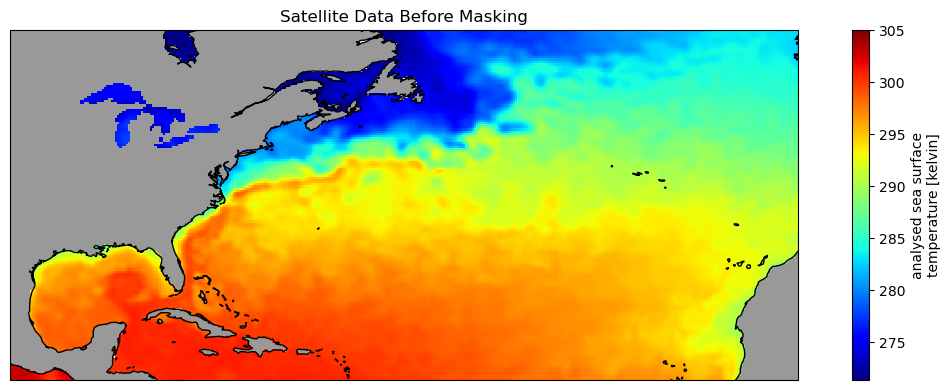

In [55]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([260, 350, 15, 55], ccrs.PlateCarree())

# set the tick marks to be slightly inside the map extents

# add feature to the map
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

sst_cm = ds_subset[0].plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), cmap='jet')
plt.title('Satellite Data Before Masking')


## Create the region from the shape file
The plot shows the shape of the region and its placement along the US East Coast. 

<GeoAxes: >

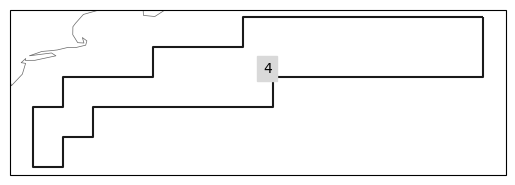

In [56]:
region = regionmask.from_geopandas(gulf_stream)
region.plot()

## Mask the satellite data


In [57]:
# Create the mask
mask = region.mask(ds_subset.lon, ds_subset.lat)

# Apply mask the the satellite data
masked_ds = ds_subset.where(mask == region.numbers[0])

## Visualize the masked data on a map
These data have been trimmed to contain only values within the Gulf Stream Province

Text(0.5, 1.0, 'Satellite Data After Masking for Longhurst GFST')

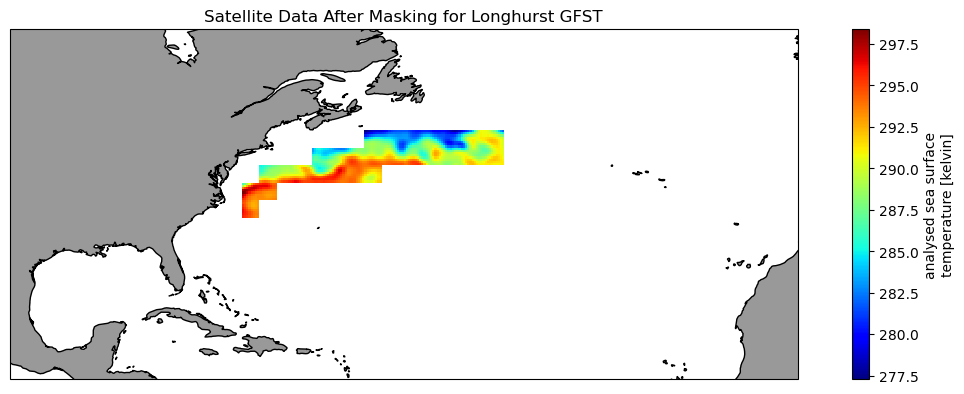

In [58]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([260, 350, 15, 55], ccrs.PlateCarree())

# add feature to the map
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

masked_ds[0].plot.pcolormesh(ax=ax1,
                             transform=ccrs.PlateCarree(),
                             cmap='jet')

plt.title('Satellite Data After Masking for Longhurst GFST');

## Calculate the mean temperature over all timesteps

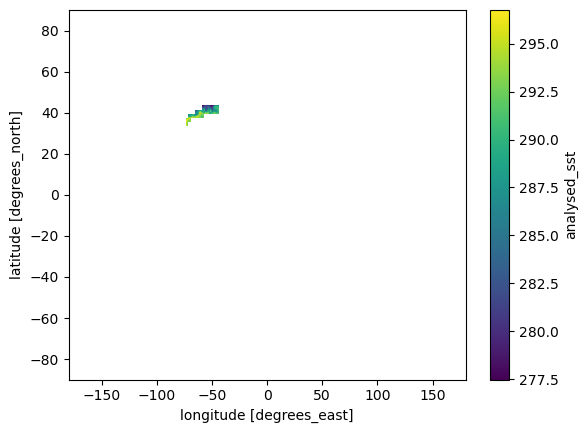

In [68]:
# Calculate mean over all time steps
sst_mean_grid = masked_ds.mean(dim='time')

# Map the SST mean
sst_mean_grid.plot()


## Calculate the mean temperature over all grids (lat, lon)

In [71]:
# Calculate mean over all grids
sst_mean_time = masked_ds.mean(dim=['lat', 'lon'])

# Plot the SST mean
plt.figure(figsize=(10, 5)) 
plt.plot_date(sst_mean_time.time,
              sst_mean_time, 
              'o', markersize=8, 
              label='gulf stream', c='black', 
              linestyle='-', linewidth=2) 

plt.title('Gulf Stream Province Daily Mean Temperature 2020')
plt.ylabel('SST (degrees C)') 
plt.xlabel('Dates')
plt.legend()

## References

* [AVHRR SST Data](https://cmr.earthdata.nasa.gov/search/concepts/C2036881712-POCLOUD.html)
* [NASA Earthdata catalog](https://search.earthdata.nasa.gov/search)
* To explore a full range of tutorials on accessing and utilizing oceanographic satellite data, visit the [NOAA CoastWatch Tutorial Github repository.](https://github.com/coastwatch-training/CoastWatch-Tutorials). These tutorials use ERDDAP servers but code for minulating the data cubes is the same as that use with data from NASA Earthdata.
* Sources for marine shape files: https://www.marineregions.org/downloads.php